In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import statistics

## Helper functions!

In [2]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [3]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

# Separate into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X,                  # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=1      # Set for reproducibility
)

# Apply scaling to relevant rows
columns_to_scale = ['ATMs', 'Shops']

scaler = StandardScaler().fit(X_train[columns_to_scale]) 
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
X_new_train = X_train.copy()
X_new_test = X_test.copy()

# Add variables - Train
X_new_train = X_new_train.drop(columns=['Downtown']).mul(X_new_train['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

X_train['Downtown_NotWeekday_Center'] = X_train['Downtown'] * (1 - X_train['Weekday'] ) * X_train['Center']
X_train["Shops_DWC"] = X_train['Downtown_NotWeekday_Center'] * X_train['Shops'] 
X_train["ATMs_DWC"] = X_train['Downtown_NotWeekday_Center'] * X_train['ATMs'] 

# Add variables - Test
X_new_test = X_new_test.drop(columns=['Downtown']).mul(X_new_test['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

X_test['Downtown_NotWeekday_Center'] = X_test['Downtown'] * (1 - X_test['Weekday'] ) * X_test['Center']
X_test["Shops_DWC"] = X_test['Downtown_NotWeekday_Center'] * X_test['Shops'] 
X_test["ATMs_DWC"] = X_test['Downtown_NotWeekday_Center'] * X_test['ATMs'] 

train = pd.concat([y_train, X_train, X_new_train], axis=1)
test = pd.concat([y_test, X_test, X_new_test], axis=1)

X_train = pd.concat([X_train, X_new_train], axis=1)
X_test = pd.concat([X_test, X_new_test], axis=1)

In [4]:
X_train.head()

,Shops,ATMs,Downtown,Weekday,Center,High,Downtown_NotWeekday_Center,Shops_DWC,ATMs_DWC,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT
7214,0.627193,0.830934,1,1,1,1,0,0.0,0.0,0.627193,0.830934,1,1,1
13522,0.534761,0.286455,1,1,0,0,0,0.0,0.0,0.534761,0.286455,1,0,0
18479,0.639356,0.014215,1,1,0,1,0,0.0,0.0,0.639356,0.014215,1,0,1
3366,0.656382,0.558694,1,1,0,1,0,0.0,0.0,0.656382,0.558694,1,0,1
21645,-1.508474,-1.346982,0,1,0,0,0,-0.0,-0.0,-0.000000,-0.000000,0,0,0


In [5]:
# 3. Model
formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  0.2695257447138808
Train MSE:  0.2714183998650767


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.903e+06
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:41:15   Log-Likelihood:                -13497.
No. Observations:               17600   AIC:                         2.702e+04
Df Residuals:                   17585   BIC:                         2.714e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     24.4818      0.904     27.090      0.000      22.710      26.253
Shops                          7.6182      0.586     12.998      0.000       6.469       8.767
ATMs                          -3.6402      0.026   -141.854      0.000      -3.690      -3.590
Downtown                      19.2437      0.906     21.242      0.000      17.468      21.019
Weekday                       -2.2179      0.016   -140.097      0.000      -2.249      -2.187
Center                         3.5909      0.024    150.685      0.000       3.544       3.638
High                           1.0376      0.016     65.919      0.000       1.007       1.068
Downtown_NotWeekday_Center    13.9386      0.367     37.988      0.000      13.219      14.658
Shops_DWC                      9.2853      0.560     16.595      0.000       8.189      10.382
ATMs_DWC                      -0.0010      0.050     -0.020      0.984      -0.100       0.098
Shops_DT                      37.6195      0.594     63.332      0.000      36.455      38.784
ATMs_DT                       -0.0388      0.027     -1.433      0.152      -0.092       0.014
Weekday__DT                    0.2242      0.019     11.631      0.000       0.186       0.262
Center_DT                     -0.5763      0.030    -19.130      0.000      -0.635      -0.517
High_DT                       -0.0506      0.019     -2.696      0.007      -0.087      -0.014
==============================================================================
Omnibus:                       65.192   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.188
Skew:                           0.113   Prob(JB):                     3.48e-16
Kurtosis:                       3.214   Cond. No.                         723.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: the MSE is already lower!

Looking at the p values, we should exclude variables `ATMs_DT` and `High_DT` from the model.


## Best Subset selection!

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [10]:
# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=train).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X_train.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf 

    for combo in itertools.combinations(X_train.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=train).fit()
        train_mse = comp_mse(model, train)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1 
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1 

        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 16384 iterations and 211.57 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=27022.59 with 14 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Downtown_NotWeekday_Center + Shops_DWC + Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT

BIC=27121.12 with 12 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Downtown_NotWeekday_Center + Shops_DWC + Shops_DT + Weekday__DT + Center_DT

test MSE: 0.27 has 12 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Downtown_NotWeekday_Center + Shops_DWC + Shops_DT + Weekday__DT + Center_DT


<Axes: >

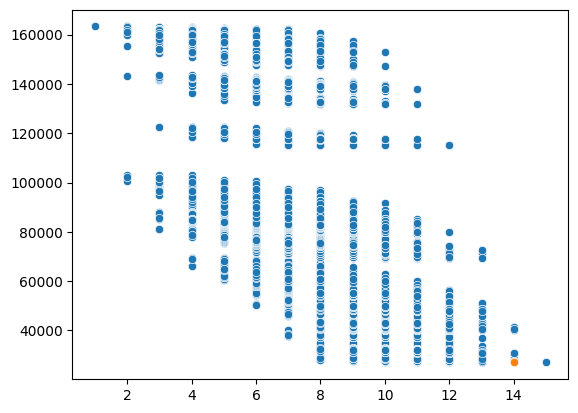

In [18]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

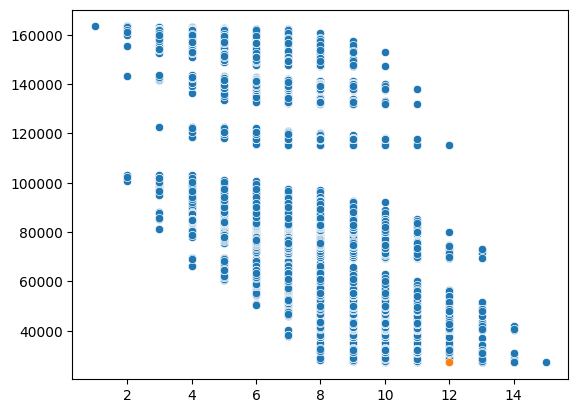

In [19]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

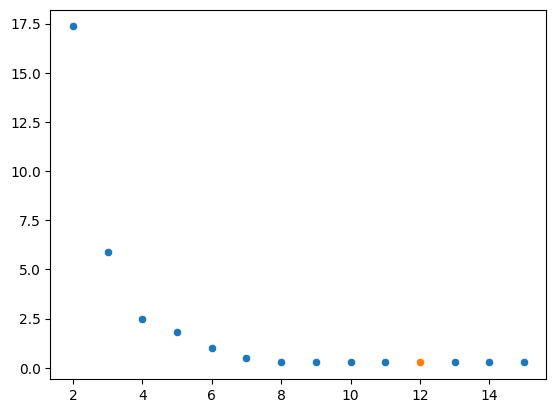

In [20]:
sns.scatterplot(x=range(1+1, len(train.columns) + 1),y=test_mse[1:])
sns.scatterplot(x=[best_p_test], y=[best_test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []

In [21]:
# 3. AIC Best Model

model = ols(best_model_aic, data=train).fit()
print("Formula is: ", best_model_aic)
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Formula is:  Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Downtown_NotWeekday_Center + Shops_DWC + Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT
Test MSE:  0.2695266206747381
Train MSE:  0.27141840573894166


In [15]:
# BIC Best Model

model = ols(best_model_bic, data=train).fit()
print("Formula is: ", best_model_bic)
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Formula is:  Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Downtown_NotWeekday_Center + Shops_DWC + Shops_DT + Weekday__DT + Center_DT
Test MSE:  0.2690572201362564
Train MSE:  0.2715607793268146


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.694e+06
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:14:05   Log-Likelihood:                -13502.
No. Observations:               17600   AIC:                         2.703e+04
Df Residuals:                   17588   BIC:                         2.712e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     24.4217      0.903     27.044      0.000      22.652      26.192
Shops                          7.6029      0.586     12.970      0.000       6.454       8.752
ATMs                          -3.6751      0.008   -455.015      0.000      -3.691      -3.659
Downtown                      19.2968      0.905     21.314      0.000      17.522      21.071
Weekday                       -2.2178      0.016   -140.082      0.000      -2.249      -2.187
Center                         3.5912      0.024    150.676      0.000       3.545       3.638
High                           1.0019      0.009    116.831      0.000       0.985       1.019
Downtown_NotWeekday_Center    13.9406      0.365     38.240      0.000      13.226      14.655
Shops_DWC                      9.2828      0.559     16.602      0.000       8.187      10.379
Shops_DT                      37.6350      0.594     63.350      0.000      36.470      38.799
Weekday__DT                    0.2244      0.019     11.636      0.000       0.187       0.262
Center_DT                     -0.5770      0.030    -19.153      0.000      -0.636      -0.518
==============================================================================
Omnibus:                       64.412   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.291
Skew:                           0.112   Prob(JB):                     5.45e-16
Kurtosis:                       3.213   Cond. No.                         686.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Test MSE Best Model

model = ols(best_model_test_mse, data=train).fit()
print("Formula is: ", best_model_test_mse)
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Formula is:  Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Downtown_NotWeekday_Center + Shops_DWC + Shops_DT + Weekday__DT + Center_DT
Test MSE:  0.2690572201362564
Train MSE:  0.2715607793268146


Doing some manual cross validation checking to assess if doing cross validation is necessary

In [ ]:
test_mse = []

formulas = [
    # Shops_DWC
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Downtown_NotWeekday_Center
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"
    ]

for formula in formulas:
    for i in range(1,21):
        columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops_DWC', 'Shops','Shops_DT']

        # 1. Separate
        X_train, X_test, y_train, y_test = train_test_split(
            X_new,              # Features
            y,                  # Target variable
            test_size=0.2,      # 20% for testing, 80% for training
            random_state=i      # Set for reproducibility
        )

        train = pd.concat([y_train,X_train], axis=1)
        test = pd.concat([y_test,X_test], axis=1)

        # 2. Scale
        scaler = StandardScaler().fit(train[columns_to_scale]) 

        train[columns_to_scale] = scaler.transform(train[columns_to_scale])
        test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
         
        model = ols(formula, data=train).fit()
        test_mse.append(comp_mse(model, test)) 

    print(f"formula is: {formula}")   
    print(f"Mean : {statistics.mean(test_mse)}")
    print(f"Max: {max(test_mse)}")
    print(f"Min: {min(test_mse)}")
    print(f"R-squared: {model.rsquared}\n")  

From these, we can see that it is a pretty stable result, thus, I don't think it is necessary to perform cross validation on the model selection. 

In [ ]:
test_mse = []

formulas = [
    # Best for 10 parameters:
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 9 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 8 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + ATMs + Downtown + Weekday + Center + High"
    ]

for formula in formulas:
    for i in range(1,21):
        columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops_DWC', 'Shops','Shops_DT']

        # 1. Separate
        X_train, X_test, y_train, y_test = train_test_split(
            X_new,              # Features
            y,                  # Target variable
            test_size=0.2,      # 20% for testing, 80% for training
            random_state=i      # Set for reproducibility
        )

        train = pd.concat([y_train,X_train], axis=1)
        test = pd.concat([y_test,X_test], axis=1)

        # 2. Scale
        scaler = StandardScaler().fit(train[columns_to_scale]) 

        train[columns_to_scale] = scaler.transform(train[columns_to_scale])
        test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
         
        model = ols(formula, data=train).fit()
        test_mse.append(comp_mse(model, test)) 

    print(f"formula is: {formula}")   
    print(f"Mean : {statistics.mean(test_mse)}")
    print(f"Max: {max(test_mse)}")
    print(f"Min: {min(test_mse)}")
    print(f"R-squared: {model.rsquared}\n")  

In [ ]:
"""
Prediction test
"""
formula = best_model_bic
# formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"
model = ols(formula, data=train).fit()
model.params

In [ ]:
uptown = train[train.Downtown == 0].copy()
uptown_target = uptown.Withdraw.copy()
uptown.drop(['Withdraw'], axis=1, inplace=True)

upper_downtown = train[(train.Downtown == 1) & (train.Weekday == 0) & (train.Center == 1)].copy()
upper_downtown_target = upper_downtown.Withdraw.copy()
upper_downtown.drop(['Withdraw'], axis=1, inplace=True)

middle_downtown = train[(train.Downtown == 1) & ((train.Weekday) == 1 | (train.Center == 0))].copy()
middle_downtown_target = middle_downtown.Withdraw.copy()
middle_downtown.drop(['Withdraw'], axis=1, inplace=True)

In [ ]:
print(f'''
        For the uptown group, we predicted {model.predict(uptown.iloc[0]).values[0]}, 
        and the actual value was {uptown_target.iloc[0]}.

        For the upper_downtown group, we predicted {model.predict(upper_downtown.iloc[0]).values[0]}, 
        and the actual value was {upper_downtown_target.iloc[0]}.

        For the middle_downtown group, we predicted {model.predict(middle_downtown.iloc[0]).values[0]}, 
        
        and the actual value was {middle_downtown_target.iloc[0]}.
        '''
)


In [ ]:
train

## Testing doing scaling before interaction variables


In [ ]:
test_mse = []

formulas = [
    # Best for 10 parameters:
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 9 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 8 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + ATMs + Downtown + Weekday + Center + High"
    ]

for formula in formulas:
    for i in range(1,21):

        # 1. Separate
        X_train, X_test, y_train, y_test = train_test_split(
            X,              # Features
            y,                  # Target variable
            test_size=0.2,      # 20% for testing, 80% for training
            random_state=i      # Set for reproducibility
        )

        train = pd.concat([y_train,X_train], axis=1)
        test = pd.concat([y_test,X_test], axis=1)

        # 2. Scale
        
        # print(train)
        prescaled_model = ols(formula, data=train).fit()
        test_mse.append(comp_mse(prescaled_model, test)) 

    print(f"formula is: {formula}")   
    print(f"Mean : {statistics.mean(test_mse)}")
    print(f"Max: {max(test_mse)}")
    print(f"Min: {min(test_mse)}")
    print(f"R-squared: {prescaled_model.rsquared}\n")  

In [ ]:
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"
prescaled_model = ols(formula, data=train).fit()
prescaled_model.params

In [ ]:
def uptown_reg(shops):
    return 23.576623 + 7.050417*shops

def downtown_mid_reg(shops):
    return (23.576623 + 20.638484) + (37.465296 + 7.050417)*shops

def downtown_upper_reg(shops):
    return (23.576623 + 20.638484 + 3.558970 -0.512589) + (37.465296 + 7.050417 + 30.603454)*shops

sns.scatterplot(x='Shops', y='Withdraw', data=scaled_data[scaled_data['Downtown'] == 0])
uptown_x = np.arange(-1.8,-1.2,0.05)
plt.plot(uptown_x, uptown_reg(uptown_x))
plt.title('Uptown')

plt.show()

sns.scatterplot(x='Shops', y='Withdraw', data=scaled_data[scaled_data['Downtown'] == 1])
downtown_x = np.arange(0.4,1,0.05)
plt.plot(downtown_x, downtown_mid_reg(downtown_x))
plt.plot(downtown_x, downtown_upper_reg(downtown_x))
plt.title('Downtown')
plt.show()